<a href="https://colab.research.google.com/github/YaroslavRomanovskiy/NS271_Romanovskii/blob/main/Example_to_Plot_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#импортируем необходимые библиотеки
import torch
import random
import pandas as pd
import numpy as np
from glob import glob
#from scripts import spym

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [2]:
from scipy import interpolate

def spline(xold, yold, xnew):
    """Spline interpolation using interpolate.CubicSpline
    xold - previous x-axis
    yold - y-data for interpolation
    xnew - new x-axis
    """
    if xold[0] > xold[-1]:
        xold = np.flipud(xold)
        yold = np.flipud(yold)
    cs = interpolate.CubicSpline(xold, yold)
    return cs(xnew)

In [3]:
import os
import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/cKFCV0Z_4I6BnA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = str(os.getcwd()+'/')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

In [4]:
dataset = pd.read_pickle('Simple_AllData1mkm.pkl')

In [5]:
dataset

,Iw_norm,Phase
0,"[-7.173206071788765, -6.248067439688921, -6.48...","[-4.083446785719934, -3.8789060673407314, -3.6..."
1,"[-7.188025160376421, -6.25558388465318, -6.505...","[-10.381189074628114, -9.762974505219404, -9.1..."
2,"[-7.1711438479901535, -6.247148365280655, -6.4...","[-5.303288121764887, -4.9842345212907215, -4.6..."
3,"[-7.195633457322558, -6.265571028669771, -6.52...","[-14.407042676483078, -13.470667414188048, -12..."
4,"[-7.196368277772776, -6.265146463284435, -6.52...","[-10.031943193905118, -9.298209866881047, -8.5..."
...,...,...
201995,"[-7.1874847052810065, -6.258618773484933, -6.5...","[-18.97986000570287, -17.69756898614764, -16.4..."
201996,"[-7.186607918480649, -6.255838716640364, -6.50...","[-5.9707741258515314, -5.5393209106848245, -5...."
201997,"[-7.187450655750165, -6.254849864903581, -6.50...","[-17.500458053811588, -16.272484726805057, -15..."
201998,"[-7.18576805980098, -6.253371851581514, -6.505...","[-3.055795200072438, -2.9161400709290364, -2.7..."


In [6]:
new_freq = np.arange(284.5,297.5, 0.2) #частотная сетка

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(torch.tensor(dataset['Iw_norm'], dtype=torch.float32), torch.tensor(dataset['Phase'], dtype=torch.float32), train_size=0.95, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

<ipython-input-7-6546456211a8>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_train, x_test, y_train, y_test = train_test_split(torch.tensor(dataset['Iw_norm'], dtype=torch.float32), torch.tensor(dataset['Phase'], dtype=torch.float32), train_size=0.95, random_state=42)


In [8]:
mean = torch.mean(x_train).item()
std = torch.std(x_train).item()

mean_phase = torch.mean(y_train).item()
std_phase = torch.std(y_train).item()

x_train_scaled = (x_train - mean)/std
x_val_scaled = (x_val - mean)/std
x_test_scaled = (x_test - mean)/std

y_train_scaled = (y_train - mean_phase)/std_phase
y_val_scaled = (y_val - mean_phase)/std_phase
y_test_scaled = (y_test - mean_phase)/std_phase

trainset = torch.utils.data.TensorDataset(x_train_scaled, y_train_scaled)
valset = torch.utils.data.TensorDataset(x_val_scaled, y_val_scaled)
testset = torch.utils.data.TensorDataset(x_test_scaled, y_test_scaled)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)#, num_workers = 5) # Здесь можно указать параметр num_workers для ускорения обучения
val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False)#, num_workers = 5) #Здесь можно указать параметр num_workers для ускорения обучения
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)#, num_workers = 5) #Здесь можно указать параметр num_workers для ускорения обучения

In [9]:
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(
            nn.Linear(130, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 65)
        )

    def forward(self, x):
        return self.core(x)

SimpleModel()

SimpleModel(
  (core): Sequential(
    (0): Linear(in_features=130, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=500, out_features=500, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=500, out_features=65, bias=True)
  )
)

In [10]:
#Загрузим модель из яндекс диска (работает в яндекс датасфере)

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/30OP3_Ed-MYOGA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = str(os.getcwd()+'/')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

ckpt_list = glob(dist_path+"/lightning_logs/version_4/checkpoints/*")
ckpt_list.sort()
ckpt_path = ckpt_list[-1]# Your code here
map_location=torch.device('cpu')
checkpoint = torch.load(ckpt_path, map_location=map_location)

checkpoint_dict = torch.load(ckpt_path,map_location=map_location)
model = checkpoint_dict["hyper_parameters"]["model"]
print(model)

SimpleModel(
  (core): Sequential(
    (0): Linear(in_features=130, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=500, out_features=500, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=500, out_features=65, bias=True)
  )
)


<ipython-input-10-868516fa85ab>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=map_location)
<ipython-input-10-868516fa85a

In [26]:
def Plot_temporal_comparison_for_Example(freq_input, intensity, intensity_SPM,
                                         true_phase, model_phase):
    """
    Функция построения на одном графике временных огибающих пары импульсов
    (второй предполагается из методики FROG)

    Параметры:
        freq_input - входная частотная сетка,
        intensity - спектральная интенсивность исходного импульса,
        intensity_SPM - спектральная интенсивность импульса после ФСМ,
        true_phase - спектральная фаза из датасета,
        model_phase - спектральная фаза модели,

    Результат:
        построение спектральных и временных графиков, вывод длительности
        импульса с фазой из датасета и фазой модели с
        процентной ошибкой восстановления длительности FWHM
    """
    freq_input=freq_input*1e12
    freq_min = np.min(freq_input)
    freq_max = np.max(freq_input)

    #New frequency grid starting from zero and linear
    N = 2**15
    T = 5000*1e-15
    dt = 2*T/(N)
    time = np.arange(-T, T, dt)
    df = 1 / 2 / T
    F = 1 / 2 / dt
    freq = np.arange(-F, F, df)
    f_filter = (freq >= freq_min) * (freq <= freq_max)

    #shifting Electric field and phase to the new grid
    intensity_= spline(freq_input, intensity, freq) * f_filter
    int_filter = intensity_ >= 0
    intensity_ = intensity_*int_filter
    intensity_ = (intensity_ - np.min(intensity_))/np.max(intensity_ - np.min(intensity_))

    model_phase_ = spline(freq_input, model_phase, freq) * f_filter
    true_phase_ = spline(freq_input, true_phase, freq) * f_filter

    Ew_model = np.sqrt(np.abs(intensity_))*np.exp(1j*model_phase_)
    Ew_true = np.sqrt(np.abs(intensity_))*np.exp(1j*true_phase_)

    #FFT and retrieving Electric field and time phase
    E_time_model = np.fft.ifftshift(np.fft.ifft(Ew_model))
    E_time_true = np.fft.ifftshift(np.fft.ifft(Ew_true))

    #retrieving temporal intensity
    intensity_temp_true = np.abs(E_time_true)**2/max(np.abs(E_time_true)**2)
    intensity_temp_model = np.abs(E_time_model)**2/max(np.abs(E_time_true)**2)

    tshft = time - time[np.where(intensity_temp_model==intensity_temp_model.max())]
    tshft2 = time - time[np.where(intensity_temp_true==intensity_temp_true.max())]

    fig, ax1 = plt.subplots(figsize = (10,4), nrows=1, ncols=2)

    #plot temporal
    ax1[0].plot(tshft*1e15, intensity_temp_model, color='orange', label = 'Model',  lw = 2)
    ax1[0].plot(tshft2*1e15, intensity_temp_true, color='blue', label = 'True',  lw = 2)
    fwhm_model = tshft[intensity_temp_model>0.5][-1] - tshft[intensity_temp_model>0.5][0]
    #print('fwhm_model = ', round(fwhm_model*1e15), 'fs')
    fwhm_true = tshft2[intensity_temp_true>0.5][-1] - tshft2[intensity_temp_true>0.5][0]
    #print('fwhm_true = ', round(fwhm_true*1e15), 'fs')
    #print('fwhm_error = ', round(100*(fwhm_model-fwhm_true)/fwhm_true,1), '%')

    ax1[0].set_xlim((-500,500))
    ax1[0].set_xlabel('Time (fs)')
    ax1[0].set_ylabel('Intensity (a.u.)')
    ax1[0].legend()
    ax1[0].text(-100, 0.3, 'fwhm_model = '+str(round(fwhm_model*1e15))+'fs', fontsize=8)
    ax1[0].text(-100, 0.2, 'fwhm_true = '+str(round(fwhm_true*1e15))+'fs', fontsize=8)
    ax1[0].text(-100, 0.1, 'fwhm_error = '+ str(round(100*(np.abs(fwhm_model-fwhm_true))/fwhm_true,1))+ '%', fontsize=8)

    #plot spectrum
    ax1[1].set_xlabel('Frequency (THz)')
    #print(k)
    ax1[1].set_ylabel('Intensity (a.u)')
    ax1[1].plot(freq_input, intensity, color='blue', label = "Init. spec.",  lw = 2)
    ax1[1].plot(freq_input, intensity_SPM, color='red',label = "SPM spec.", lw = 2)
    vert_line1_coord = np.where(intensity>1e-2)
    ax1[1].axvline(x=freq_input[vert_line1_coord[0][0]], ls='-.', color='black')
    ax1[1].axvline(x=freq_input[vert_line1_coord[0][-1]],ls='-.', color='black')
    #ax1.plot(wavelength_frog, spectr_frog, label = "FROG",  lw = 2)
    #ax1.tick_params(axis='y', labelcolor=color)
    ax1[1].set_xlim(freq_input[0], freq_input[-1])
    #ax1.set_ylim(1e-3, 1.05)
    ax1[1].legend(loc = 'upper left')
    ax2 = ax1[1].twinx()
    #color[i][j] = 'tab:blue'
    ax2.set_ylabel('Phase (rad)')
    ax2.plot(freq_input, true_phase,'--',  label = "true phase",  lw = 2, color='blue')#, 's', ms = 3, mew = 3, markevery= 1, linestyle = "None")
    ax2.plot(freq_input, model_phase,'--', label = "model phase",  lw = 2, color='orange')
    #ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc = 'upper right')
    ax2.set_ylim(-15, 15)

    fig.tight_layout()
    plt.show()



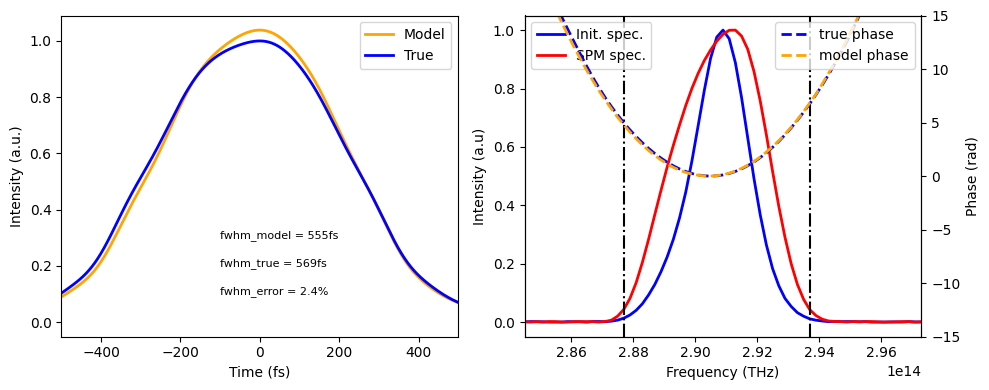

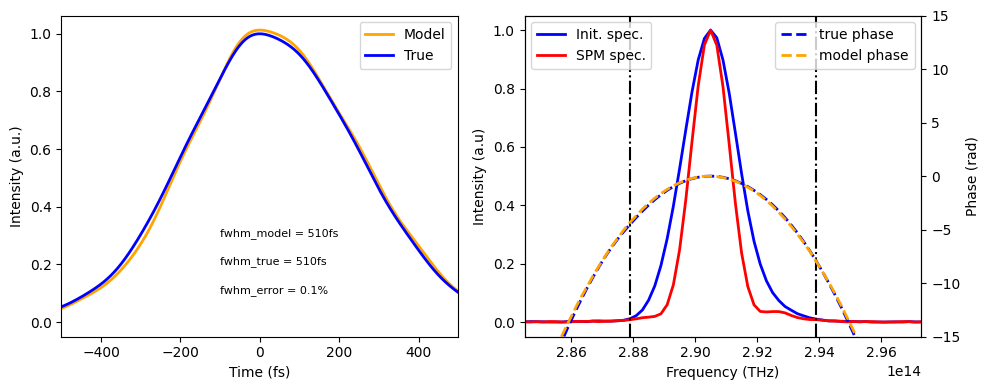

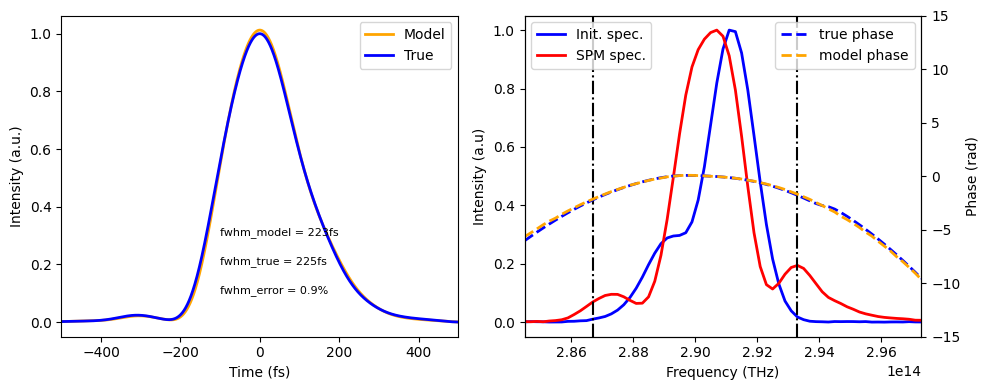

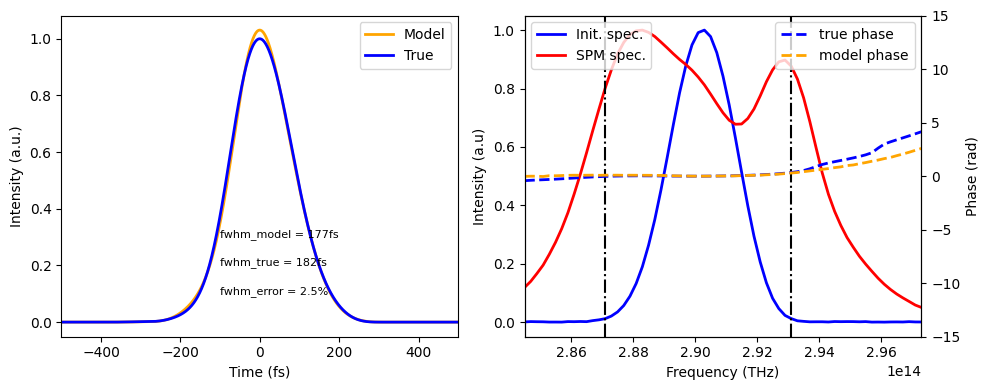

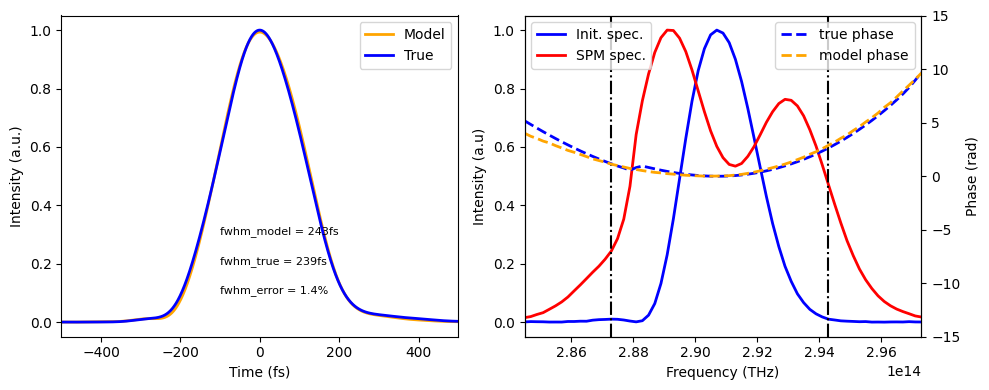

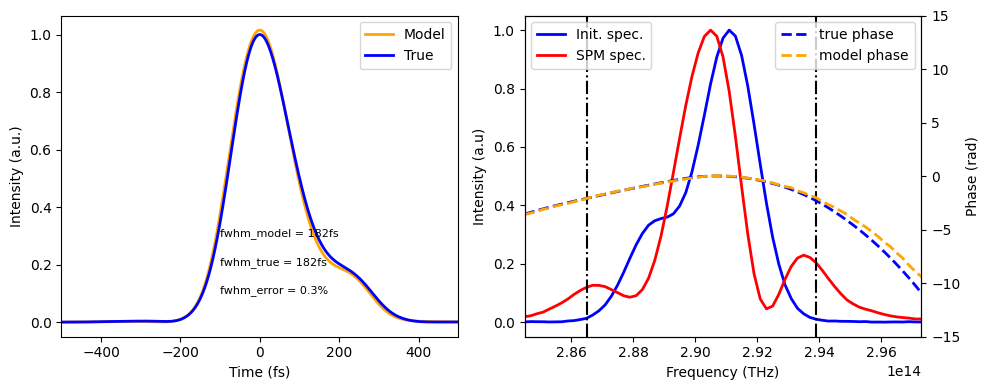

In [27]:
index_reference = [166, 9015, 3061, 5808, 9557, 7240, 1557]
model_phase = np.zeros((len(index_reference),65))
model.eval()
i=0
for idx in index_reference:
    x = x_test_scaled[index_reference[i]].unsqueeze(0)#.cuda()
    model_phase[i] = model(x).squeeze(0).cpu().detach().numpy() * std_phase + mean_phase
    i=i+1

k=0
for i in range(6):
    Plot_temporal_comparison_for_Example(new_freq, np.exp(x_test[index_reference[k]][0:65]), np.exp(x_test[index_reference[k]][65:]),
                                         y_test[index_reference[k]], model_phase[i])
    k=k+1

